# **YOUNGER - Age Estimator**

# **IV. PREPROCESSING**

## **4.1 Contents**
* 4.1 Contents
* 4.2 Introduction
* 4.3 Imports
* 4.4 Load Data
* 4.5 Transform Data
* 4.6 Train/Test Split
* 4.7 Data Augmentation
* 4.8 Transfer Learning
* Summary


---



##**4.2 Introduction**

Previously, to create an age-predictor, we have completed a notebook import data and explore its attributes: [Data Wrangling & Exploratory Data Analysis](https://github.com/premonish/YOUNGER/blob/main/notebooks/YOUNGER_Age_Estimator_WRANGLING_EDA_v2.ipynb). We took a close look at the metadata and plotted some histograms of the variable distributions. We transformed the data to extract the age of the primary face in each image from their date-of-birth and the date the photo was taken. We focused on extracting a large array of vectors of the pixel information per photo. We finished the previous phase by creating 2 arrays: 'matrix_x' containing the (150,000+ pixel/image) data from each image in the dataset, and 'vector_y' containing the corresponding 'age' labels for the images. 

In this notebook, we will focus on Preprocessing & Modeling. In particular, we will use a Convolutional Neural Network, which is industry standard for Machine Learning image classification tasks due to its unmatched performance.  


---



**Historical Context** 
>
> Image classification has been around for decades, however the field has been rapidly maturing in the last decade.  Since 2010, [ImageNet](https://https://en.wikipedia.org/wiki/ImageNet) Large Scale Visual Recognition Challenge (ILSVRC) is an annual competition where teams attempt to categorize thousands of images into 1,000 classes. In 2012, 'AlexNet' won the competition by a landslide and this is considered a pivotal moment in the history of deep learning, enabled by ingenious data scientists, a massive labeled dataset, and GPUs for training.




**PREPROCESSING** will be focused on three main sections.

1. Create Dummy Variables for categorical variables where appropriate.
2. Standardize the magnitude of numeric features using a scaler.
3. Split data into testing and training datasets.

**MODELING** will focus on the following four phases.
1. Train the models on the dataset (fit)
2. Review model performance metrics
3. Iterate over other models
4. Identify the final model  


---



## **4.3 Imports**

In [ ]:
# !pip install tensorflow

In [ ]:
# Create a list of currently installed python libraries for posterity
# !pip freeze > requirements.txt

In [ ]:
### IMPORT libraries and packages ###
### I get by with a little help from my friends ###
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# deep-learning imports
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
from keras import metrics
from keras.models import model_from_json

# import os
# import PIL
# from PIL import Image
# import seaborn as sns
# from pathlib import Path
# import random
# import requests
# import scipy.io
# from keras.preprocessing import image
# from keras.applications.resnet import preprocess_input
# from datetime import datetime, date, time, timedelta

In [ ]:
# mount GDrive where the dataset is stored for Colab environment
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **4.4 Load Data**
Let's load the compressed numpy arrays from disk, extract data, and check the number of rows in our dataset.

In [ ]:
%%time
from numpy import asarray, savez_compressed, load
# load dict of arrays
images = np.load('/content/drive/MyDrive/YOUNGER/data2.npz', allow_pickle=True)
matrix_x = images.f.arr_0
matrix_x.shape

CPU times: user 1min 4s, sys: 9.73 s, total: 1min 13s
Wall time: 1min 14s


In [ ]:
# load the ages array 'vector_y'
ages = np.load('/content/drive/MyDrive/YOUNGER/vector_y.npz', allow_pickle=True)
vector_y = ages.f.arr_0
vector_y.shape

(22138,)

In [ ]:
# check output matrix_x & vector_y shapes
# both matrix_x and vector_y are arrays of the same length 
assert vector_y.shape == matrix_x.shape

In [ ]:
# subset data
X0 = matrix_x[:5000]
X1 = matrix_x[5000:10000]
# X2 = matrix_x[10000:12000]
# X3 = matrix_x[15000:20000]
# X4 = matrix_x[20000:]

### NOTE: I'm running some tests to see how many images to include without overwhelming Google Colab's Ram. 
### I have already upgraded to Colab Pro for this project and have been reaching the RAM limits

y = vector_y[:10000]
# convert to tensor
# [tf.convert_to_tensor(a) for a in X]
# [tf.convert_to_tensor(a) for a in y];

## **4.5 Transform Data**

**One-Hot Encoding**

We need to encode the 'ages' label as categorical (binary) representations to prevent a hierarchical interpretation. 
The Keras API provides a 'to_categorical()' method that can be used to one-hot encode integer data. 

In [ ]:
classes = 101 # ages 0 to 100
target = y
target_classes = keras.utils.to_categorical(target, classes) # "Converts a class vector (integers) to binary class matrix." 

**Reshaping the Data**

We must reshape the data into the standard input array shape of a 'rank 4 tensor' to prepare for the Tensorflow CNN.

(b, w, h, c) : (batch, width, height, channels)

In [ ]:
# features = []
# for i in range(0, len(X)):
#     features.append(X[i])
# features = np.array(features)
# features = features.reshape(len(X),224,224,3)
# features.shape

In [ ]:
#### TEST ###$#$#$
### NOTE: I'm running some tests to see how many images to include without overwhelming Google Colab's Ram. 
### I have already upgraded to Colab Pro for this project and have been reaching the RAM limits
%%time
features = []
for i in range(0, len(X0)):
    features.append(X0[i])
for i in range(0, len(X1)):
    features.append(X1[i])
# for i in range(0, len(X2)):
#     features.append(X2[i])
# for i in range(0, len(X3)):
#     features.append(X3[i])
features = np.array(features)

CPU times: user 818 ms, sys: 1.08 s, total: 1.9 s
Wall time: 1.89 s


In [ ]:
features = features.reshape(len(features),224,224,3)
features.shape

(10000, 224, 224, 3)

**Scale the Data**

Each of the pixel values range from 0-255. Let's scale the values to from 0-1 by dividing each value by 255. Interestingly, we are actually performing this operation virtually instantly 150,528 times per image (times the number of images).

In [ ]:
features /= 255 # scale down pixel values to range [0, 1]
print("The maximum value in our dataset is:", features.max())

The maximum value in our dataset is: 1.0


## **4.6 Train/Test Split**
We will divide the dataset randomly into training data and test data. We will later perform data augmentation on only the training set to help balance the classes of ages in the dataset.

In [ ]:
# train/ test split
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(features, target_classes, test_size=0.20)

In [ ]:
# print("X_train shape =",X_train.shape,"| X_test shape =",X_test.shape)
# print("y_train shape =",y_train.shape,"| y_test shape =",y_test.shape)

print("X_train shape =",train_x.shape,"| X_test shape =",test_x.shape)
print("y_train shape =",train_y.shape,"| y_test shape =",test_y.shape)

X_train shape = (8000, 224, 224, 3) | X_test shape = (2000, 224, 224, 3)
y_train shape = (8000, 101) | y_test shape = (2000, 101)


## **4.7 Data Augmentation**
Balance the classes by upsampling the underrepresented classes. ImageDataGenerator creates transformed images to expand the training segment of the dataset.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(train_x);

## **4.8 Transfer Learning**

I'll start by testing an established effective architecture (VGG-Face model) for this task along with trained weights. ***[UPDATE REQUIRED: INCLUDE CITATION & DETAILS]***.

In [ ]:
#VGG-Face model
model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

In [ ]:
model.load_weights('/content/drive/MyDrive/YOUNGER/vgg_face_weights.h5')

In [ ]:
for layer in model.layers[:-7]:
  layer.trainable = False
 
base_model_output = Sequential()
base_model_output = Convolution2D(101, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)
 
age_model = Model(inputs=model.input, outputs=base_model_output)

In [ ]:
# check trainable layers
if False:
    for layer in model.layers:
        print(layer, layer.trainable)
    
    print("------------------------")
    for layer in age_model.layers:
        print(layer, layer.trainable)

In [ ]:
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

age_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  #, optimizer = sgd
                  , metrics=['accuracy']
                 )

In [ ]:
checkpointer = ModelCheckpoint(
    filepath='/content/classification_age_model.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

In [ ]:
scores = []

In [ ]:
enableFit = True

if enableFit:
    # epochs = 250 # original
    batch_size = 256 # original
    epochs = 100
    # batch_size = 32

    for i in range(epochs):
        print("epoch ",i)
        
        ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        
        score = age_model.fit(
            train_x[ix_train], train_y[ix_train]
            , epochs=1
            , validation_data=(test_x, test_y)
            , callbacks=[checkpointer]
        )
        
        scores.append(score)
    
    #restore the best weights
    from keras.models import load_model
    age_model = load_model('/content/classification_age_model.hdf5')
    
    age_model.save_weights('/content/drive/MyDrive/YOUNGER/age_model_weights.h5')
        
else:
    #pre-trained weights for age prediction: https://drive.google.com/file/d/1YCox_4kJ-BYeXq27uUbasu--yz28zUMV/view?usp=sharing
    age_model.load_weights("/content/drive/MyDrive/YOUNGER/age_model_weights.h5")

epoch  0
8/8 [==============================] - 96s 13s/step - loss: 4.5647 - accuracy: 0.0162 - val_loss: 4.3427 - val_accuracy: 0.0345

Epoch 00001: val_loss improved from inf to 4.34271, saving model to /content/classification_age_model.hdf5
epoch  1
8/8 [==============================] - 96s 13s/step - loss: 4.2960 - accuracy: 0.0508 - val_loss: 4.1456 - val_accuracy: 0.0325

Epoch 00001: val_loss improved from 4.34271 to 4.14562, saving model to /content/classification_age_model.hdf5
epoch  2
8/8 [==============================] - 94s 13s/step - loss: 4.0340 - accuracy: 0.0352 - val_loss: 4.0126 - val_accuracy: 0.0340

Epoch 00001: val_loss improved from 4.14562 to 4.01258, saving model to /content/classification_age_model.hdf5
epoch  3
8/8 [==============================] - 93s 13s/step - loss: 3.9470 - accuracy: 0.0195 - val_loss: 3.9963 - val_accuracy: 0.0310

Epoch 00001: val_loss improved from 4.01258 to 3.99634, saving model to /content/classification_age_model.hdf5
epoch  4

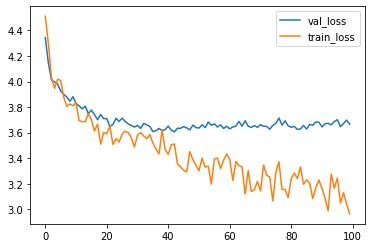

In [ ]:
val_loss_change = []; loss_change = []
for i in range(0, len(scores)):
    val_loss_change.append(scores[i].history['val_loss'])
    loss_change.append(scores[i].history['loss'])

plt.plot(val_loss_change, label='val_loss')
plt.plot(loss_change, label='train_loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#loss and accuracy on validation set
age_model.evaluate(test_x, test_y, verbose=1)

63/63 [==============================] - 65s 1s/step - loss: 3.6066 - accuracy: 0.0465


[3.606576681137085, 0.04650000110268593]

In [ ]:
predictions = age_model.predict(test_x)

In [ ]:
output_indexes = np.array([i for i in range(0, 101)])
apparent_predictions = np.sum(predictions * output_indexes, axis = 1)

In [ ]:
mae = 0
for i in range(0 ,apparent_predictions.shape[0]):
    prediction = int(apparent_predictions[i])
    actual = np.argmax(test_y[i])
    
    abs_error = abs(prediction - actual)
    # actual_mean = actual_mean + actual
    
    mae = mae + abs_error
    
    mae = mae / apparent_predictions.shape[0]

print("mae: ",mae)
print("instances: ",apparent_predictions.shape[0])

mae:  0.0025015016255626565
instances:  2000


In [ ]:
def loadImage(filepath):
    test_img = image.load_img(filepath, target_size=(224, 224))
    test_img = image.img_to_array(test_img)
    test_img = np.expand_dims(test_img, axis = 0)
    test_img /= 255
    return test_img

In [ ]:
from keras.preprocessing import image
picture = "/content/drive/MyDrive/YOUNGER/face_old.jpeg"
# picture = "/content/drive/MyDrive/YOUNGER/Baby-Face-Cute.jpg"
# picture = "/content/drive/MyDrive/YOUNGER/prem_linked.jpg"
# picture = '/content/drive/MyDrive/YOUNGER/pinky_linkedIn.jpg'

prediction = age_model.predict(loadImage(picture))

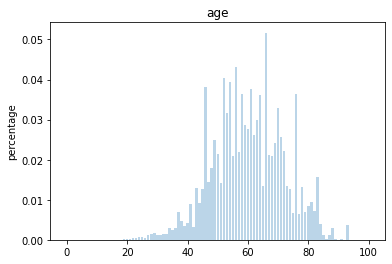

In [ ]:
y_pos = np.arange(101)
plt.bar(y_pos, prediction[0], align='center', alpha=0.3)
plt.ylabel('percentage')
plt.title('age')
plt.show()

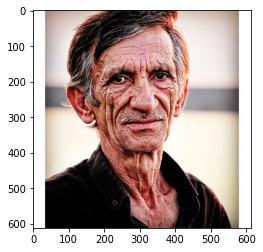

Dominant Age Class:  66


In [ ]:
img = image.load_img(picture)#, target_size=(224, 224))
plt.imshow(img)
plt.show()

print("Dominant Age Class: ",np.argmax(prediction))
apparent_age = np.round(np.sum(prediction * output_indexes, axis = 1))
# print("apparent age: ", int(apparent_age[0]))
# print("Predicted Age:",((np.argmax(prediction))+ (int(apparent_age[0])))/2)



---


# **SUMMARY**


---
##**To be updated...**

# **REFERENCES**


1.   https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ 
2.   https://data.vision.ee.ethz.ch/cvl/publications/papers/proceedings/eth_biwi_01229.pdf
3. https://sefiks.com/2019/02/13/apparent-age-and-gender-prediction-in-keras/ 
4. https://www.researchgate.net/publication/265125544_Face_Detection_without_Bells_and_Whistles
5. https://github.com/yu4u/age-gender-estimation

---